# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [183]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import pandas as pd

In [184]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 17, 23, 15, 20, 439215)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
project = hopsworks.login()

fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1162392
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [186]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=2,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [187]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [188]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.3132626E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [189]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-19 00:00:00+00:00,17.950001,0.0,4.510787,208.610367,barcelona
1,2024-11-20 00:00:00+00:00,18.049999,0.0,2.414953,296.564972,barcelona
2,2024-11-18 00:00:00+00:00,14.750000,0.0,2.902413,277.124908,barcelona
3,2024-11-21 00:00:00+00:00,18.200001,0.0,24.693481,277.539337,barcelona
4,2024-11-22 00:00:00+00:00,17.250000,0.0,12.413477,299.538696,barcelona
5,2024-11-23 00:00:00+00:00,13.800000,0.0,7.895416,294.227722,barcelona
6,2024-11-24 00:00:00+00:00,19.150000,0.0,11.753877,242.650208,barcelona
7,2024-11-25 00:00:00+00:00,19.400000,0.0,7.091177,246.037506,barcelona
8,2024-11-26 00:00:00+00:00,19.850000,0.0,2.620839,164.054535,barcelona


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [166]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-19 00:00:00+00:00,17.950001,0.0,8.049845,243.435013,barcelona,67.926918
1,2024-11-20 00:00:00+00:00,18.549999,0.0,4.024922,259.695221,barcelona,70.095581
2,2024-11-18 00:00:00+00:00,15.600000,0.0,3.600000,233.130020,barcelona,68.527855
3,2024-11-21 00:00:00+00:00,18.350000,0.0,24.693481,277.539337,barcelona,27.695644
4,2024-11-22 00:00:00+00:00,16.450001,0.0,20.617662,282.094727,barcelona,21.148497
5,2024-11-23 00:00:00+00:00,15.000000,0.0,11.841756,250.463257,barcelona,32.231068
6,2024-11-24 00:00:00+00:00,18.549999,0.0,14.587776,254.248749,barcelona,35.918076
7,2024-11-25 00:00:00+00:00,18.150000,0.0,8.891344,201.370682,barcelona,56.792789
8,2024-11-26 00:00:00+00:00,20.600000,0.0,7.903619,239.931503,barcelona,70.380814


In [167]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 456.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [168]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data_mon = batch_data
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
2,2024-11-18 00:00:00+00:00,15.600000,0.0,3.600000,233.130020,barcelona,68.527855,barcelona-carrer_de_valencia-95,spain,3
0,2024-11-19 00:00:00+00:00,17.950001,0.0,8.049845,243.435013,barcelona,67.926918,barcelona-carrer_de_valencia-95,spain,1
1,2024-11-20 00:00:00+00:00,18.549999,0.0,4.024922,259.695221,barcelona,70.095581,barcelona-carrer_de_valencia-95,spain,2
3,2024-11-21 00:00:00+00:00,18.350000,0.0,24.693481,277.539337,barcelona,27.695644,barcelona-carrer_de_valencia-95,spain,4
4,2024-11-22 00:00:00+00:00,16.450001,0.0,20.617662,282.094727,barcelona,21.148497,barcelona-carrer_de_valencia-95,spain,5
5,2024-11-23 00:00:00+00:00,15.000000,0.0,11.841756,250.463257,barcelona,32.231068,barcelona-carrer_de_valencia-95,spain,6
6,2024-11-24 00:00:00+00:00,18.549999,0.0,14.587776,254.248749,barcelona,35.918076,barcelona-carrer_de_valencia-95,spain,7
7,2024-11-25 00:00:00+00:00,18.150000,0.0,8.891344,201.370682,barcelona,56.792789,barcelona-carrer_de_valencia-95,spain,8
8,2024-11-26 00:00:00+00:00,20.600000,0.0,7.903619,239.931503,barcelona,70.380814,barcelona-carrer_de_valencia-95,spain,9


In [169]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


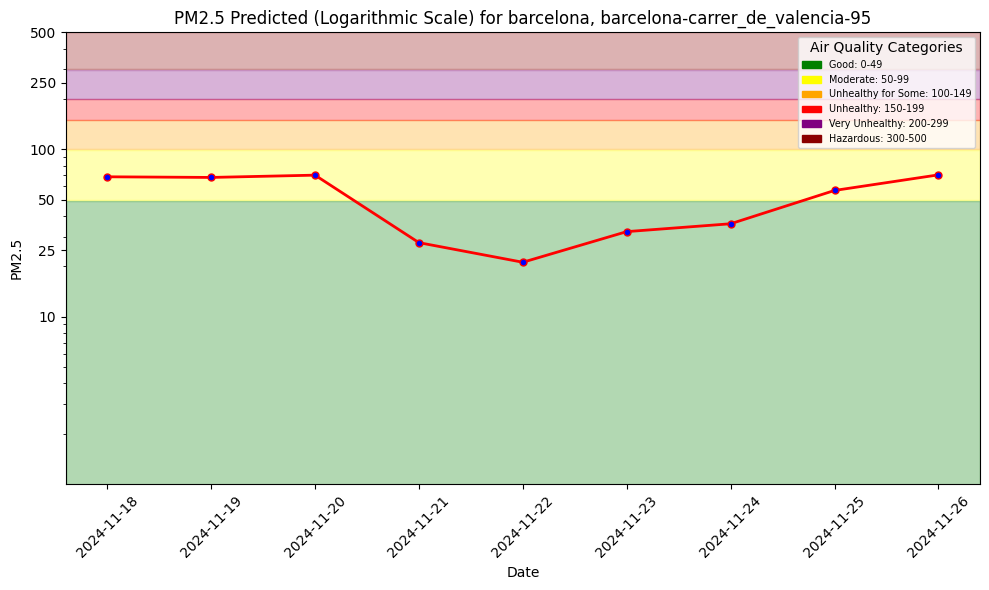

In [170]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast_first.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

### Adding Rolling_PM25

In [171]:

batch_data = batch_data.sort_values(by='date', ascending=False)
batch_data = batch_data.reset_index(drop=True)

def calculate_future_rolling_mean(df, column, window):
    rolling_means = []
    for i in range(len(df)):
        # the next `window` is at index + 1
        future_values = df[column].iloc[i+1:i+1+window]
        # mean
        rolling_mean = future_values.mean()
        rolling_means.append(rolling_mean)
    return rolling_means

# apply the function

batch_data['rolling_pm25'] = calculate_future_rolling_mean(batch_data, 'predicted_pm25', window=3)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day,rolling_pm25
0,2024-11-26 00:00:00+00:00,20.600000,0.0,7.903619,239.931503,barcelona,70.380814,barcelona-carrer_de_valencia-95,spain,9,41.647308
1,2024-11-25 00:00:00+00:00,18.150000,0.0,8.891344,201.370682,barcelona,56.792789,barcelona-carrer_de_valencia-95,spain,8,29.765879
2,2024-11-24 00:00:00+00:00,18.549999,0.0,14.587776,254.248749,barcelona,35.918076,barcelona-carrer_de_valencia-95,spain,7,27.025070
3,2024-11-23 00:00:00+00:00,15.000000,0.0,11.841756,250.463257,barcelona,32.231068,barcelona-carrer_de_valencia-95,spain,6,39.646572
4,2024-11-22 00:00:00+00:00,16.450001,0.0,20.617662,282.094727,barcelona,21.148497,barcelona-carrer_de_valencia-95,spain,5,55.239380
5,2024-11-21 00:00:00+00:00,18.350000,0.0,24.693481,277.539337,barcelona,27.695644,barcelona-carrer_de_valencia-95,spain,4,68.850121
6,2024-11-20 00:00:00+00:00,18.549999,0.0,4.024922,259.695221,barcelona,70.095581,barcelona-carrer_de_valencia-95,spain,2,68.227386
7,2024-11-19 00:00:00+00:00,17.950001,0.0,8.049845,243.435013,barcelona,67.926918,barcelona-carrer_de_valencia-95,spain,1,68.527855
8,2024-11-18 00:00:00+00:00,15.600000,0.0,3.600000,233.130020,barcelona,68.527855,barcelona-carrer_de_valencia-95,spain,3,NaN


In [172]:
# set API key 
AQI_API_KEY = secrets.get_secret("AQI_API_KEY").value
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
aqicn_url=location['aqicn_url']

past_data = []

# get data for past 3 days - to calculate rolling pm25
for i in range(3):
    day = datetime.date.today() - datetime.timedelta(days=i)
    aq_day_df = util.get_pm25(aqicn_url, country, city, street, day, AQI_API_KEY)
    past_data.append(aq_day_df)

aq_past_three_days_df = pd.concat(past_data, ignore_index=True)

In [173]:
pm25_mean = aq_past_three_days_df['pm25'].mean()
batch_data['rolling_pm25'] = batch_data['rolling_pm25'].fillna(pm25_mean)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day,rolling_pm25
0,2024-11-26 00:00:00+00:00,20.600000,0.0,7.903619,239.931503,barcelona,70.380814,barcelona-carrer_de_valencia-95,spain,9,41.647308
1,2024-11-25 00:00:00+00:00,18.150000,0.0,8.891344,201.370682,barcelona,56.792789,barcelona-carrer_de_valencia-95,spain,8,29.765879
2,2024-11-24 00:00:00+00:00,18.549999,0.0,14.587776,254.248749,barcelona,35.918076,barcelona-carrer_de_valencia-95,spain,7,27.025070
3,2024-11-23 00:00:00+00:00,15.000000,0.0,11.841756,250.463257,barcelona,32.231068,barcelona-carrer_de_valencia-95,spain,6,39.646572
4,2024-11-22 00:00:00+00:00,16.450001,0.0,20.617662,282.094727,barcelona,21.148497,barcelona-carrer_de_valencia-95,spain,5,55.239380
5,2024-11-21 00:00:00+00:00,18.350000,0.0,24.693481,277.539337,barcelona,27.695644,barcelona-carrer_de_valencia-95,spain,4,68.850121
6,2024-11-20 00:00:00+00:00,18.549999,0.0,4.024922,259.695221,barcelona,70.095581,barcelona-carrer_de_valencia-95,spain,2,68.227386
7,2024-11-19 00:00:00+00:00,17.950001,0.0,8.049845,243.435013,barcelona,67.926918,barcelona-carrer_de_valencia-95,spain,1,68.527855
8,2024-11-18 00:00:00+00:00,15.600000,0.0,3.600000,233.130020,barcelona,68.527855,barcelona-carrer_de_valencia-95,spain,3,55.000000


In [174]:
# load another model - trained with rolling_pm25

### VERSION = 3

mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

Connected. Call `.close()` to terminate connection gracefully.


XGBRegressor(base_score='4.31749E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [175]:
batch_data = batch_data.drop(columns=['predicted_pm25'])

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['rolling_pm25','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,country,days_before_forecast_day,rolling_pm25,predicted_pm25
0,2024-11-26 00:00:00+00:00,20.600000,0.0,7.903619,239.931503,barcelona,barcelona-carrer_de_valencia-95,spain,9,41.647308,60.291355
1,2024-11-25 00:00:00+00:00,18.150000,0.0,8.891344,201.370682,barcelona,barcelona-carrer_de_valencia-95,spain,8,29.765879,37.466572
2,2024-11-24 00:00:00+00:00,18.549999,0.0,14.587776,254.248749,barcelona,barcelona-carrer_de_valencia-95,spain,7,27.025070,24.767330
3,2024-11-23 00:00:00+00:00,15.000000,0.0,11.841756,250.463257,barcelona,barcelona-carrer_de_valencia-95,spain,6,39.646572,43.648304
4,2024-11-22 00:00:00+00:00,16.450001,0.0,20.617662,282.094727,barcelona,barcelona-carrer_de_valencia-95,spain,5,55.239380,34.493935
5,2024-11-21 00:00:00+00:00,18.350000,0.0,24.693481,277.539337,barcelona,barcelona-carrer_de_valencia-95,spain,4,68.850121,44.038437
6,2024-11-20 00:00:00+00:00,18.549999,0.0,4.024922,259.695221,barcelona,barcelona-carrer_de_valencia-95,spain,2,68.227386,62.265427
7,2024-11-19 00:00:00+00:00,17.950001,0.0,8.049845,243.435013,barcelona,barcelona-carrer_de_valencia-95,spain,1,68.527855,66.465355
8,2024-11-18 00:00:00+00:00,15.600000,0.0,3.600000,233.130020,barcelona,barcelona-carrer_de_valencia-95,spain,3,55.000000,74.199303


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

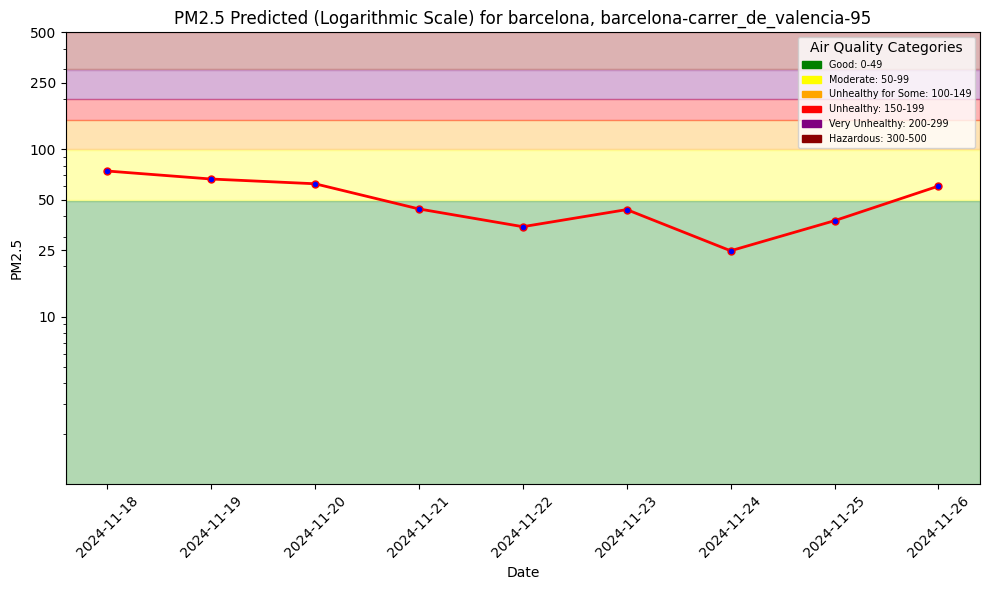

In [176]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [177]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [178]:
monitor_fg.insert(batch_data_mon, write_options={"wait_for_job": True, "timeout": 200})


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1162392/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2b31b17c0>, None)

In [179]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,17.650000,0.0,4.320000,180.000000,barcelona,76.156738,barcelona-carrer_de_valencia-95,spain,1
1,2024-11-11 00:00:00+00:00,19.200001,0.0,7.771331,166.607483,barcelona,72.612648,barcelona-carrer_de_valencia-95,spain,1
2,2024-11-15 00:00:00+00:00,15.750000,0.0,4.104631,127.875046,barcelona,79.639801,barcelona-carrer_de_valencia-95,spain,1
3,2024-11-19 00:00:00+00:00,17.950001,0.0,8.049845,243.435013,barcelona,67.926918,barcelona-carrer_de_valencia-95,spain,1


In [180]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 


,date,pm25,country,city,street,url
0,2023-05-25 00:00:00+00:00,48.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669
1,2024-06-23 00:00:00+00:00,43.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669
2,2023-02-17 00:00:00+00:00,67.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669
3,2024-09-09 00:00:00+00:00,24.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669
4,2024-02-28 00:00:00+00:00,26.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669
...,...,...,...,...,...,...
1008,2024-11-13 00:00:00+00:00,34.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669
1009,2024-11-14 00:00:00+00:00,50.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669
1010,2024-11-15 00:00:00+00:00,46.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669
1011,2024-11-16 00:00:00+00:00,50.0,spain,barcelona,barcelona-carrer_de_valencia-95,https://api.waqi.info/feed/@6669


In [181]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-11 00:00:00+00:00,72.612648,38.0
0,2024-11-14 00:00:00+00:00,76.156738,50.0
2,2024-11-15 00:00:00+00:00,79.639801,46.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

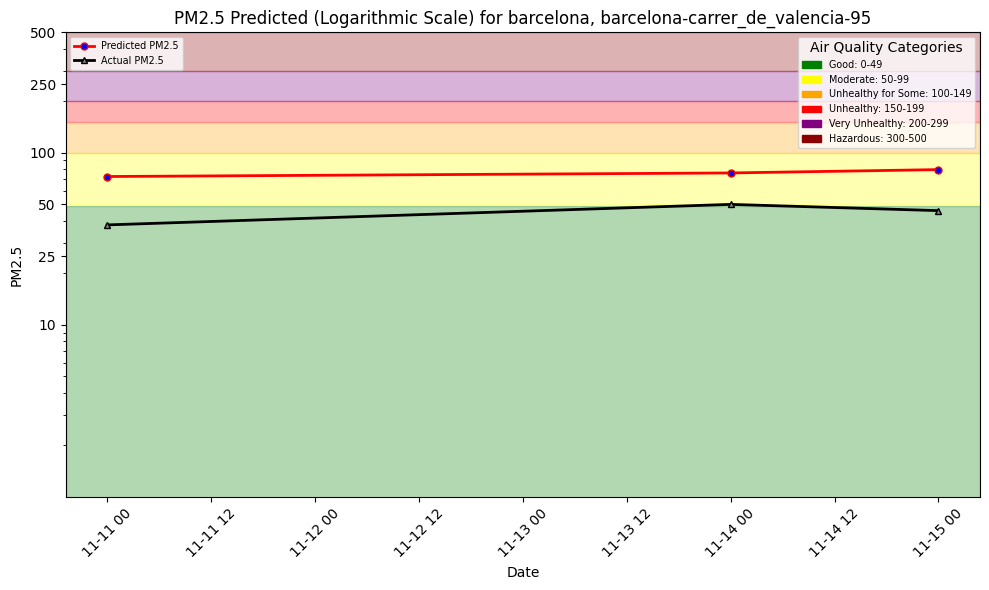

In [182]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---